In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

device='cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0))

Mounted at /content/drive
Tesla P100-PCIE-16GB


# Load data files
* Network has 118 nodes and 169 (concatenated from 176) edges
* Uniform load (input) dataset
* 1 original network and 9 networks with topology disturbances and corresponding solutions
* Network perturbations generated by a random process following a binomial distribution 

* Load nominal system data
- Data pre-stored in pickle files

In [ ]:
filename = '/content/drive/MyDrive/gnn/data/data_2383dc_topo_3inputs/ieee2383dc_topo_load1.txt'
file_price = '/content/drive/MyDrive/gnn/data/data_2383dc_topo_3inputs/ieee2383dc_topo_lmp_nominal1.txt'
filepath = '/content/drive/My Drive/gnn/data/data_2383dc_topo_3inputs/' # DC-OPF

load_data0=pd.read_table(filename,sep=',',header=None).to_numpy()
lmp_data=pd.read_table(file_price,sep=',',header=None).to_numpy()

# generator cost data
filename = filepath + 'ieee2383dc_topo_topo_cost1.txt' 
gen_cost0 = pd.read_table(filename,sep=',',header=None).to_numpy()
# generator limit data
filename = filepath + 'ieee2383dc_topo_topo_pgmax1.txt' 
gen_limit0 = pd.read_table(filename,sep=',',header=None).to_numpy()

# efficient index
filename = filepath + 'ieee2383dc_topo_set2_effective_idx.txt' 
eff_idx0 = pd.read_table(filename,sep=',',header=None).to_numpy()
eff_idx_node = eff_idx0[:,0]
n_sample_nominal = sum(eff_idx_node)
print(n_sample_nominal)

filename = filepath + 'ieee2383dc_topo_set2_effective_idx_loc.txt' 
eff_idx0 = pd.read_table(filename,sep=',',header=None).to_numpy()
eff_idx_node1 = eff_idx0[0].copy()

2944


In [ ]:
print(eff_idx_node)
print(eff_idx_node1)
print(sum(eff_idx_node))

[0 1 1 ... 0 1 1]
[   2    3    4 ... 3997 3999 4000]
2944


In [ ]:
print(load_data0.shape,lmp_data.shape,gen_cost0.shape,gen_limit0.shape)

(2383, 4000) (2383, 2944) (2383, 2944) (2383, 2944)


In [ ]:
# filepath = '/content/drive/My Drive/gnn/data/data_118ac_topo_3inputs_new1/'
filepath = '/content/drive/My Drive/gnn/data/data_2383dc_topo_3inputs/' # DC-OPF

sys_params = np.load(filepath + 'pickle/dc2383_p10_sys_nominal.npy')

## load injection
# system size
n_bus=int(sys_params[0,0].copy())
n_line=int(sys_params[1,0].copy()) # not concatenated
n_double_line = 9
n_line = n_line - n_double_line
# n_line=179
n_load=int(sys_params[2,0].copy())
n_sample=int(sys_params[3,0].copy())
# line
line_bus=sys_params[:,1:3].copy()

load_data=np.zeros((n_bus,3,n_sample))
load_data[:,0,:]=load_data0[:,:n_sample].copy()
for i in range(n_sample_nominal):
  # print(eff_idx_node1[i])
  # print(gen_cost0[0,i])
  load_data[:,1,eff_idx_node1[i]-1]=gen_cost0[:,i].copy()
  load_data[:,2,eff_idx_node1[i]-1]=gen_limit0[:,i].copy()


# x = np.load(filepath + 'pickle/dc2383_p10_x_nominal.npy')
# y = np.load(filepath + 'pickle/dc2383_p10_y_nominal.npy')
x = load_data.copy()
y = lmp_data.copy()
W = np.load(filepath + 'pickle/dc2383_p10_w_nominal.npy')

print('Nominal system (w/out outage):')
# print('Test case: ',filename)
print('Number of buses: ',n_bus)
print('Number of lines: ',n_line)
print('Number of loads: ',n_load)
print('Number of samples: ',n_sample)

Nominal system (w/out outage):
Number of buses:  2383
Number of lines:  2887
Number of loads:  1822
Number of samples:  4000


* Load perturbed system data

In [ ]:
filename = filepath + 'ieee2383dc_topo_set2_effective_idx.txt'
effective_index = pd.read_table(filename,sep=',',header=None).to_numpy()
# effective_index = np.load(filepath + '/pickle/dc2383_p10_effective_idx.npy')
# print(effective_index.shape())

topo_pert_num = np.size(effective_index,1) - 1
print('Systems w/ topo. perturb:',topo_pert_num)

effective_samples0 = np.sum(effective_index[:,0],0)
effective_index0 = effective_index[:,0].copy()

effective_samples = np.sum(effective_index[:,1:],0)
print('Nominal effective samples:',effective_samples0)
print('Effective samples for topo. changes:',effective_samples)

# lmp_pert = np.load(filepath + 'pickle/dc2383_p10_y_pert.npy')
# # print(gen_pert.shape,lmp_pert.shape)
# print(lmp_pert.shape)
# print(np.max(lmp_pert),np.min(lmp_pert))

Systems w/ topo. perturb: 0
Nominal effective samples: 2944
Effective samples for topo. changes: []


In [ ]:
#@title
# # Graph generating function
# def build_system_graph(src,dst):
#     # Edges are directional in DGL; Make them bi-directional.
#     # Matlab counts from 1 and python from 0
#     u = np.concatenate([src, dst])-1 
#     v = np.concatenate([dst, src])-1
#     # Construct a DGLGraph
#     return dgl.DGLGraph((u, v))

# line_src = line_bus[:,0].copy()
# line_dst = line_bus[:,1].copy()
# G = build_system_graph(line_src.astype(int),line_dst.astype(int))
# print('There are %d nodes.' % G.number_of_nodes())
# print('There are %d edges.' % G.number_of_edges())

# import networkx as nx
# # Since the actual graph is undirected, we convert it for visualization
# # purpose.
# nx_G = G.to_networkx().to_undirected()
# # Kamada-Kawaii layout usually looks pretty for arbitrary graphs
# pos = nx.kamada_kawai_layout(nx_G)
# nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [ ]:
#@title
n_sample0 = n_sample
print('Test summary:')
print('Number of buses: ',n_bus)
print('Number of lines: ',n_line)
print('Number of loads: ',n_load)
print('Number of samples in load: ',n_sample0)
print('Number of effective samples in nominal system: ',effective_samples0)
print('Number of perturbation cases:',topo_pert_num)
print('Number of effective perturbation cases:',effective_samples)

Test summary:
Number of buses:  2383
Number of lines:  2887
Number of loads:  1822
Number of samples in load:  4000
Number of effective samples in nominal system:  2944
Number of perturbation cases: 0
Number of effective perturbation cases: []


* Calculate laplacian (W loaded)

In [ ]:
#@title

# W loaded by pickle

# line_src = line_bus[:,0].copy().astype(int)
# line_dst = line_bus[:,1].copy().astype(int)
# print('Original graph:')
# print('There are %d nodes.' % n_bus)
# print('There are %d edges.' % n_line)

# # adjacency
# def graph_v2v_mat(line,n_line,n_bus):
# 	w = np.zeros((n_bus,n_bus))
# 	for i in range(n_line):
# 		# print(int(line[i,0]),int(line[i,1]))
# 		w[int(line[i,0])-1,int(line[i,1])-1] = 1
# 		w[int(line[i,1])-1,int(line[i,0])-1] = 1
# 	return w

# def graph_laplacian(line,n_line,n_bus):
# 	incidence = np.zeros((n_line,n_bus))
# 	for i in range(n_line):
# 		# print(int(line[i,0]),int(line[i,1]))
# 		incidence[i,int(line[i,0])-1] = incidence[i,int(line[i,0])-1] + 1 # source
# 		incidence[i,int(line[i,1])-1] = incidence[i,int(line[i,1])-1] - 1 # destination
# 	w = np.matmul(incidence.transpose(),incidence)
# 	return w
# W = graph_laplacian(line_bus,n_line,n_bus) # v2v
# # W=np.abs(W)

* Generate training dataset

In [ ]:
#@title
# load_data, gen_nominal, flow_nominal, lmp_nominal
# print(np.size(load_data,1))
# effective_samples0 = 5994 # done earlier
# load_e0 = np.zeros((n_bus,effective_samples0))
# idx = 0
# for i in range(np.size(load_data,1)):
#   if effective_index0[i] > 0:
#     idx = idx + 1 
#     load_e = load_data[:,i].copy()
#     load_e0[:,idx - 1] = load_e.copy()
# print(idx,load_e0.shape,load_data.shape)

In [ ]:
# efficient index
filename = filepath + 'ieee2383dc_topo_set2_effective_idx.txt' 
eff_idx0 = pd.read_table(filename,sep=',',header=None).to_numpy()
eff_idx_node = eff_idx0[:,0]
n_sample_nominal = sum(eff_idx_node)
print(n_sample_nominal)

x_nominal = np.zeros((n_bus, 3, n_sample_nominal))
for i in range(n_sample_nominal):
  x_nominal[:,:,i]=x[:,:,eff_idx_node[i]].copy()

2944


In [ ]:
print(x_nominal.shape,y.shape)

filepath1 = '/content/drive/My Drive/gnn/data/data_2383dc_topo_3inputs' # DC-OPF
np.save(filepath1+'/pickle/dc2383_x_set2.npy',arr=x_nominal)
np.save(filepath1+'/pickle/dc2383_y_set2.npy',arr=y)

(2383, 3, 2944) (2383, 2944)


In [ ]:
##@title
# Set the ratio of training/test set
n_sample = effective_samples0
train_ratio = 0.85

print(x.shape,y.shape)
print(np.max(x),np.min(x),np.max(y),np.min(y))

# x_train,x_test,y_train,y_test = train_test_split(x.transpose(),y.transpose(),test_size=1-train_ratio, random_state=18)
x_train,x_test,y_train,y_test = train_test_split(x_nominal.transpose(),y.transpose(),test_size=1-train_ratio, random_state=18)
x_train=x_train.transpose()
x_test=x_test.transpose()
y_train=y_train.transpose()
y_test=y_test.transpose()
print('Training data size:',x_train.shape)
print('Training label size:',y_train.shape)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features=torch.from_numpy(np.transpose(features)).float()
        self.labels=torch.from_numpy(np.transpose(labels)).float()
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()
        # Select sample
        X = self.features[idx]  # shape = (24,)
        y = self.labels[idx]    # shape = (24,)
        X = np.reshape(X,(3,2383))
        y = np.reshape(y,(1,2383))
        return X, y
params = {'batch_size': 200,
          'shuffle': False,
          'num_workers': 2}
# Dataset Generators
training_set = Dataset(features=x_train,labels=y_train)
training_generator = torch.utils.data.DataLoader(training_set,**params)
validation_set = Dataset(features=x_test,labels=y_test)
validation_generator = torch.utils.data.DataLoader(validation_set,**params)
print(x_train.shape,y_train.shape)

(2383, 3, 4000) (2383, 2944)
2520.0 -9.5226 1050.2 -64.584
Training data size: (2383, 3, 2502)
Training label size: (2383, 2502)
(2383, 3, 2502) (2383, 2502)


In [ ]:
##@title
from torch.autograd import Variable

device='cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0))

# One layer Graph convolution from nodes to edges
class Graph_convolution_v2v_W(nn.Module):
    def __init__(self,in_features,out_features,W,bias=True):
        super(Graph_convolution_v2v_W,self).__init__()
        self.register_buffer('w',torch.from_numpy(W.transpose()).float())
        # self.scale=nn.Parameter(torch.Tensor(1,in_features))
        self.mapping=nn.Parameter(torch.Tensor(W.shape[0],W.shape[1]))
        torch.nn.init.xavier_uniform_(self.mapping.data)
        self.scale=nn.Parameter(torch.Tensor(out_features,in_features))
        torch.nn.init.xavier_uniform_(self.scale.data)
        self.bias=nn.Parameter(torch.Tensor(out_features,1))
        torch.nn.init.xavier_uniform_(self.bias.data)

    def forward(self,input):
        h=torch.mul(self.mapping,self.w)
        h=torch.matmul(input,h) # transpose due to batch generator 
        h=torch.matmul(self.scale,h)
        return h+self.bias 

# GNN using DGL v2v graph convolution and our own v2e graph convolution
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, W, num_bus):
        super(GCN, self).__init__()
        self.conv_v2v1=Graph_convolution_v2v_W(in_feats,hidden_size[0],W)
        self.conv_v2v2=Graph_convolution_v2v_W(hidden_size[0],hidden_size[1],W)
        self.conv_v2v3=Graph_convolution_v2v_W(hidden_size[1],hidden_size[2],W)
        self.conv_v2v4=Graph_convolution_v2v_W(hidden_size[2],hidden_size[3],W)
        # self.conv_v2v5=Graph_convolution_v2v_W(hidden_size[3],hidden_size[4],W)
        # self.conv_v2v6=Graph_convolution_v2v_W(hidden_size[4],hidden_size[5],W)
        # self.conv_v2v7=Graph_convolution_v2v_W(hidden_size[5],hidden_size[6],W)
        # self.conv_v2v8=Graph_convolution_v2v_W(hidden_size[6],hidden_size[7],W)
        self.lin_output = nn.Linear(num_bus,num_bus)
         
    def forward(self, inputs):
        # m = nn.ELU()
        # m = nn.LeakyReLU()
        # m = nn.Tanh()
        m = nn.ReLU()
        h=self.conv_v2v1(inputs)
        # h=m(h)
        h=self.conv_v2v2(h)
        h=m(h)
        h=self.conv_v2v3(h)
        # h=m(h)
        h=self.conv_v2v4(h)
        h=m(h)
        # h=self.conv_v2v5(h)
        # # h=m(h)
        # h=self.conv_v2v6(h)
        # h=m(h)
        # h=self.conv_v2v7(h)
        # # h=m(h)
        # h=self.conv_v2v8(h)
        # h=m(h)
        h = self.lin_output(h)
        return h
n_bus=x.shape[0]
# w_params=[10,15,15,10,10,10,10,1]
w_params=[10,15,10,1]
net=GCN(3,w_params,W,n_bus) # Laplacian
# warm start?
# path=filepath+'trained_model/'+'ieee118ac_trained_params.pickle'
# net.load_state_dict(torch.load(path))
net=net.to(device)

# set loss_func & optimizer
loss_func=nn.MSELoss()
def my_loss_func(pred,label,W1):
  mse=loss_func(pred,label)
  lmda1=torch.from_numpy(np.array([1])).to(device) # L_2
  lmda2=torch.from_numpy(np.array([0.1])).to(device) # L_inf
  # lmda3=torch.from_numpy(np.array([0.01])).to(device) # locality
  linf=(pred-label).norm(p=float('inf'))
  return lmda1*mse + lmda2*linf
optimizer=torch.optim.Adam(net.parameters(),weight_decay=0.01)
loss_optm=[]
loss_val=[]
print(net)

Tesla P100-PCIE-16GB
GCN(
  (conv_v2v1): Graph_convolution_v2v_W()
  (conv_v2v2): Graph_convolution_v2v_W()
  (conv_v2v3): Graph_convolution_v2v_W()
  (conv_v2v4): Graph_convolution_v2v_W()
  (lin_output): Linear(in_features=2383, out_features=2383, bias=True)
)


# Model complexity

In [ ]:
#@title 
# print(net)
# n_params = 0
# n_params_trainable = 0
# for temp in net.parameters():
#     # print(temp.shape[0])
#     n_params += temp.shape[0] * temp.shape[1]
#     if abs(temp.shape[0] - n_bus) > 0:
#       n_params_trainable += temp.shape[0] * temp.shape[1]
#     else:
#       n_params_trainable += n_bus + 2 * n_line
# print('Number of GNN parameters:',n_params)
# print('Number of effective GNN parameters:',n_params_trainable)

In [ ]:
##@title
# Load the pre-trained model
path = filepath + '/trained_model/ieee2383dc_trained_params.pickle'
## A good recorded trained net 01242022
# path = filepath + '/trained_model/ieee2383dc_trained_params_01242022.pickle'
# torch.save(net.state_dict(), path)
# net_new = GCN(1, w_params, n_bus) # Laplacian
net.load_state_dict(torch.load(path))

# ## Training

max_epochs=200
eval_epoch=5

# earlystopping
tolerance=5
min_delta=1e-4
previous=0

W_tensor = torch.from_numpy(W).float().to(device)
for epoch in range(max_epochs):
  # training loop
  train_loss=0.0
  for local_batch,local_label in training_generator:
    optimizer.zero_grad() # clear the past gradient
    local_batch,local_label=local_batch.to(device),local_label.to(device)
    logits=net(local_batch)
    loss=my_loss_func(logits,local_label,W_tensor)

    loss.backward()
    train_loss+=loss.item()
    optimizer.step() # update parameters of net

  loss_optm.append(train_loss/len(training_generator.dataset))
  print("Epoch %d | Training loss: %.4f"%(epoch,train_loss/len(training_generator.dataset)))
  # eval
  if (epoch+1)%eval_epoch==0:
    net.eval()
    eval_loss=0.0
    for local_batch,local_label in validation_generator:
      local_batch,local_label=local_batch.to(device),local_label.to(device)
      logits=net(local_batch)
      loss=my_loss_func(logits,local_label,W_tensor)
      eval_loss+=loss.item()
    eval_avg=eval_loss/len(validation_generator.dataset)
    print("Epoch %d | Eval loss: %.4f" % (epoch, eval_avg))
    loss_val.append([epoch, eval_loss/len(validation_generator.dataset)])
    if epoch!=0 and previous-eval_avg<min_delta:
      tolerance-=1
      if tolerance==0: break
    previous=eval_avg
    net.train()

Epoch 0 | Training loss: 1.4814
Epoch 1 | Training loss: 1.1192
Epoch 2 | Training loss: 1.0614
Epoch 3 | Training loss: 1.0529
Epoch 4 | Training loss: 1.0485
Epoch 4 | Eval loss: 1.3513
Epoch 5 | Training loss: 1.0478
Epoch 6 | Training loss: 1.0472
Epoch 7 | Training loss: 1.0472
Epoch 8 | Training loss: 1.0474
Epoch 9 | Training loss: 1.0473
Epoch 9 | Eval loss: 1.3508
Epoch 10 | Training loss: 1.0476
Epoch 11 | Training loss: 1.0477
Epoch 12 | Training loss: 1.0476
Epoch 13 | Training loss: 1.0480
Epoch 14 | Training loss: 1.0474
Epoch 14 | Eval loss: 1.3510
Epoch 15 | Training loss: 1.0477
Epoch 16 | Training loss: 1.0479
Epoch 17 | Training loss: 1.0479
Epoch 18 | Training loss: 1.0477
Epoch 19 | Training loss: 1.0489
Epoch 19 | Eval loss: 1.3516
Epoch 20 | Training loss: 1.0476
Epoch 21 | Training loss: 1.0485
Epoch 22 | Training loss: 1.0482
Epoch 23 | Training loss: 1.0479
Epoch 24 | Training loss: 1.0494
Epoch 24 | Eval loss: 1.3523
Epoch 25 | Training loss: 1.0477
Epoch 26 

6


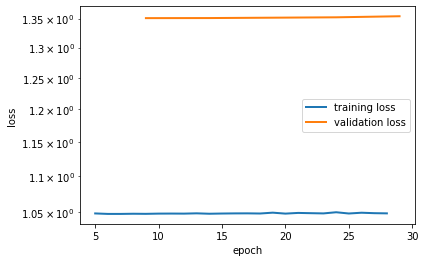

In [ ]:
#@title

import matplotlib.pyplot as plt

val_len = len(loss_val)
print(val_len)
val_plt = np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i] = loss_val[i][0]
  val_plt[1,i] = loss_val[i][1]

plt.figure()
plot_idx = np.arange(np.size(loss_optm))
# plt.plot(plot_idx,loss_optm,lw=2,label='training loss')
# plt.plot(val_plt[0,:],val_plt[1,:],lw=2,label='validation loss')
plt.plot(plot_idx[5:-1],loss_optm[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

* Save the trained model

In [ ]:
# # Save the pre-trained model
# path = filepath + '/trained_model/ieee2383dc_trained_params_set2.pickle'
# torch.save(net.state_dict(), path)
# print(filepath)

# Evaluate the model w/ validation set

In [ ]:
# validation_set = Dataset(features=x_test, labels=y_test)
# validation_generator = torch.utils.data.DataLoader(validation_set, **params)
# for local_batch, local_labels in validation_generator:
#   # Transfer to GPU
#   local_batch, local_labels = local_batch.to(device), local_labels.to(device)
#   logits = net(local_batch)

n_test = np.size(x_test,2)

x_test_feed = torch.from_numpy(np.transpose(x_test)).float()
x_test_feed = x_test_feed#.transpose(1,2)
x_test_feed = x_test_feed.to(device)
print('Validation dataset size:',x_test_feed.shape)
print('Number of validation set: ',n_test)
# y_pred = np.zeros((x_test_feed.shape))
# for i in range(n_test):
#   y_pred[i,:] = net(x_test_feed[i,:])
y_pred = net(x_test_feed)

Validation dataset size: torch.Size([442, 3, 2383])
Number of validation set:  442


 - Evaluate the trained model using validation set and visualize error

In [ ]:
y_pred1 = y_pred.cpu().detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
print(y_test.shape)

(2383, 442)


In [ ]:
n_test = np.size(y_test,1)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_test[:,i] - y_pred1[:,i]) / np.linalg.norm(y_test[:,i])
  err_Linf[i] = np.max(np.abs(y_test[:,i] - y_pred1[:,i])) / np.max(np.abs(y_test[:,i]))

err_expand = []
for i in range(10):
  err_expand.append(err_L2)
err_expand = np.array(err_expand)
print(err_L2.shape,err_expand.shape)

(442,) (10, 442)


# Visualization




L2 mean: 0.08715147373180483 L2 variance: 0.0005303349103651298 L_inf mean: 0.7718339972641107
p5: 0.04801885215459549 p95: 0.11361681010328675


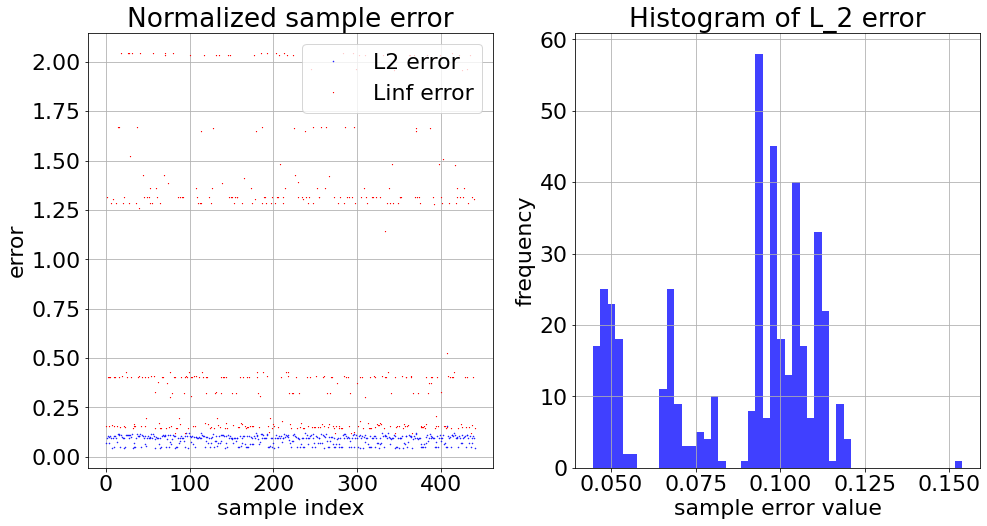

In [ ]:
err_L2_mean = np.mean(err_L2)
err_L2_var = np.var(err_L2)
err_Linf_mean = np.mean(err_Linf)
print('L2 mean:', err_L2_mean,'L2 variance:', err_L2_var,'L_inf mean:', err_Linf_mean )

err_p5 = np.percentile(err_L2,5)
err_p95 = np.percentile(err_L2,95)
print('p5:',err_p5,'p95:',err_p95)

plt.rcParams.update({'font.size': 22})
fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_L2, bins = 50, facecolor='b', alpha=0.75)
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()